In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

import vb_lib.structure_model_lib as structure_model_lib
import vb_lib.data_utils as data_utils
import vb_lib.cavi_lib as cavi_lib
import vb_lib.fast_structure_lib as fast_structure_lib
import vb_lib.plotting_utils as plotting_utils
import vb_lib.structure_optimization_lib as structure_optimization_lib

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib, optimization_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

# Load data

In [3]:
data_file = '../../../../fastStructure/test/testdata.npz'
data = np.load(data_file)
g_obs = np.array(data['g_obs'])

g_obs = np.array(data['g_obs'])
g_obs_raw = np.array(data['g_obs_raw'])

# just checking ... 
which_missing = (g_obs_raw == 3)
(g_obs.argmax(-1) == g_obs_raw)[~which_missing].all()
(g_obs[which_missing] == 0).all()

DeviceArray(True, dtype=bool)

In [4]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

# Load fastStructure fit

In [5]:
filename = '../../../../fastStructure/fits/test/testoutput_simple.3'

In [6]:
fs_vb_params_dict, vb_params_paragami = fast_structure_lib.load_fs_to_vb_params(filename)

In [7]:
fs_e_ind_admix, fs_e_pop_freq = plotting_utils.get_vb_expectations(fs_vb_params_dict)

### Check against fast-structure saved means

In [8]:
_fs_e_ind_admix, _, _fs_e_pop_freq, _ = \
    fast_structure_lib.load_fs_means_vars(filename)

In [9]:
np.abs(fs_e_pop_freq - _fs_e_pop_freq).max()

DeviceArray(5.01246185e-07, dtype=float64)

In [10]:
np.abs(fs_e_ind_admix - _fs_e_ind_admix).max()

DeviceArray(4.99500499e-07, dtype=float64)

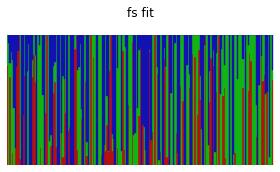

In [11]:
plotting_utils.plot_admixture(fs_e_ind_admix, 'fs fit')

# Define prior

In [12]:
use_bnp_prior = False
prior_params_dict, prior_params_paragami = structure_model_lib.get_default_prior_params()

In [13]:
prior_params_dict

{'dp_prior_alpha': DeviceArray([3.], dtype=float64),
 'allele_prior_alpha': DeviceArray([1.], dtype=float64),
 'allele_prior_beta': DeviceArray([1.], dtype=float64)}

# Evaluate objective

In [14]:
structure_model_lib.get_kl(g_obs, fs_vb_params_dict, prior_params_dict, use_bnp_prior = use_bnp_prior)

foo


DeviceArray(97039.203313, dtype=float64)

# Optimize

If fast structure found a good optimum, and my objective is correct, this shouldn't take many steps ... 

In [15]:
init_vb_params_dict = fs_vb_params_dict

In [16]:
# get optimization objective 
optim_objective, init_vb_free = \
    structure_optimization_lib.define_structure_objective(g_obs, init_vb_params_dict,
                        vb_params_paragami,
                        prior_params_dict,
                        use_bnp_prior = False,
                        compile_hvp = True)

Compiling objective ...
foo
Iter 0: f = 97039.20331300
Compiling grad ...
foo
Compiling hvp ...
foo
Compile time: 43.2566secs


In [17]:
from scipy import optimize

In [36]:
optim_objective.set_log_every(1)

In [37]:
out = optimize.minimize(optim_objective.f_np,
                        x0 = onp.array(init_vb_free),
                        jac = optim_objective.grad_np,
                        hessp = optim_objective.hvp_np, 
                        method='trust-ncg')

Iter 14: f = 97039.20331300
Iter 15: f = 97032.00482517
Iter 16: f = 97022.85348825
Iter 17: f = 97014.80295360
Iter 18: f = 96988.40425605
Iter 19: f = 96729.49736784
Iter 20: f = -23566.14897420
Iter 21: f = -272881.06390412
Iter 22: f = -254988.09892033
Iter 23: f = -274841.14637266
Iter 24: f = -393677.35796970
Iter 25: f = -1485462.67991593
Iter 26: f = -2875567.33884541
Iter 27: f = -2889064.31547037
Iter 28: f = -2896537.50115573
Iter 29: f = -2899990.51642727
Iter 30: f = -2901754.15163928
Iter 31: f = -2902676.87763938
Iter 32: f = -2902980.97114473
Iter 33: f = -2903068.56116740
Iter 34: f = -2903105.16316243
Iter 35: f = -2903171.80936272
Iter 36: f = -2903184.95053694
Iter 37: f = -2984822.03072356


ValueError: array must not contain infs or NaNs

In [38]:
foo = optim_objective.optimization_log[-1][1]

In [39]:
foo_dict = vb_params_paragami.fold(foo, free = True)

In [40]:
structure_model_lib.get_kl(g_obs, foo_dict, prior_params_dict, use_bnp_prior = use_bnp_prior)

foo


DeviceArray(-2984822.03072357, dtype=float64)

In [41]:
from vb_lib.structure_model_lib import *

In [42]:
e_log_sticks, e_log_1m_sticks, \
        e_log_pop_freq, e_log_1m_pop_freq = \
            get_moments_from_vb_params_dict(foo_dict)

In [43]:
dp_prior_alpha = prior_params_dict['dp_prior_alpha']
allele_prior_alpha = prior_params_dict['allele_prior_alpha']
allele_prior_beta = prior_params_dict['allele_prior_beta']

In [44]:
e_loglik, z_entropy = get_e_joint_loglik_from_nat_params(g_obs,
                                    e_log_pop_freq, e_log_1m_pop_freq,
                                    e_log_sticks, e_log_1m_sticks,
                                    dp_prior_alpha, allele_prior_alpha,
                                    allele_prior_beta,
                                    use_bnp_prior = use_bnp_prior,
                                    detach_ez = False)


In [45]:
z_entropy

DeviceArray(47085.47769944, dtype=float64)

In [46]:
e_loglik

DeviceArray(12188064.5631425, dtype=float64)

In [47]:
get_e_log_prior(e_log_sticks, e_log_1m_sticks,
                            e_log_pop_freq, e_log_1m_pop_freq,
                            dp_prior_alpha, allele_prior_alpha,
                            allele_prior_beta, use_bnp_prior)

DeviceArray([12328864.81541414], dtype=float64)

In [48]:
k_approx = e_log_pop_freq.shape[1]
ind_mix_prior = (1 / k_approx - 1) * modeling_lib.\
                    get_e_log_cluster_probabilities_from_e_log_stick(e_log_sticks, 
                                                                     e_log_1m_sticks).sum()

In [49]:
ind_mix_prior

DeviceArray(12328864.81541414, dtype=float64)

In [52]:
modeling_lib.get_e_log_cluster_probabilities_from_e_log_stick(e_log_sticks, e_log_1m_sticks).min()

DeviceArray(-1000013.31055961, dtype=float64)

In [53]:
np.argwhere(modeling_lib.get_e_log_cluster_probabilities_from_e_log_stick(e_log_sticks, e_log_1m_sticks) < -1000000)

DeviceArray([[  9,   1],
             [  9,   2],
             [ 30,   1],
             [ 30,   2],
             [ 52,   1],
             [ 52,   2],
             [ 63,   1],
             [ 63,   2],
             [ 78,   1],
             [ 78,   2],
             [111,   1],
             [111,   2],
             [121,   1],
             [121,   2],
             [149,   1],
             [149,   2],
             [159,   1],
             [159,   2]], dtype=int64)

In [54]:
e_log_sticks[111]

DeviceArray([-1.69801950e-11, -1.94642655e+00], dtype=float64)

In [55]:
e_log_1m_sticks[111]

DeviceArray([-1.00001136e+06, -1.64717438e+00], dtype=float64)

In [57]:
foo_dict['ind_mix_stick_beta_params'][111]

DeviceArray([[5.88944695e+04, 1.00000020e-06],
             [3.23994279e-01, 3.54547532e-01]], dtype=float64)

In [83]:
sp.special.digamma(1e-16)

DeviceArray(-1.e+16, dtype=float64)

In [25]:
out = optimization_lib.run_lbfgs(optim_objective, init_vb_free, maxiter = 3)


Running L-BFGS-B ... 
Iter 39: f = 97039.20331300
Iter 40: f = 97032.00481962
Iter 41: f = 97014.16273961
Iter 42: f = 96943.05915009
Iter 43: f = -320485.36676732
Iter 44: f = -509802871679494651904.00000000
Iter 45: f = -4122304199192395570945392780009779749738879720539991180039134835042864529898733568.00000000
Iter 46: f = nan
Iter 47: f = nan
Iter 48: f = nan
Iter 49: f = nan
Iter 50: f = nan
Iter 51: f = nan
Iter 52: f = nan
Iter 53: f = nan
Iter 54: f = nan
Iter 55: f = nan
Iter 56: f = nan
Iter 57: f = nan
Iter 58: f = nan
Iter 59: f = nan
Iter 60: f = nan
Iter 61: f = nan
Iter 62: f = 100304.71975755
Iter 63: f = 97010.25281043
done. Elapsed 3.26915secs
Iter 64: f = 97010.25281043
objective value:  97010.252810429


In [22]:
np.abs(out.x - init_vb_free).max()

NameError: name 'out' is not defined

In [19]:
vb_opt = out.x
vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)

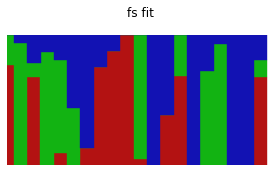

In [20]:
plotting_utils.plot_admixture(fs_e_ind_admix[0:20], 'fs fit')

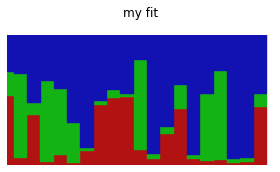

In [24]:
est_e_ind_admix, est_e_pop_freq = plotting_utils.get_vb_expectations(vb_opt_dict)
plotting_utils.plot_admixture(est_e_ind_admix[0:20], 'my fit')

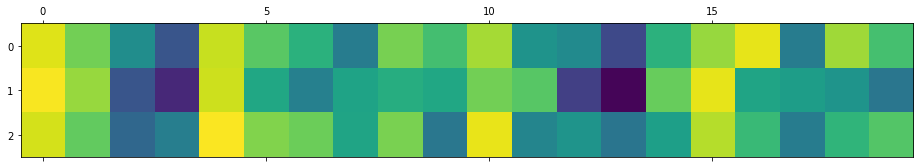

In [22]:
plt.matshow(est_e_pop_freq[0:20].transpose(), 
            vmax = 1, vmin = 0)

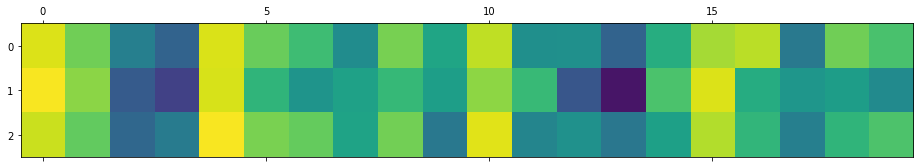

In [23]:
plt.matshow(fs_e_pop_freq[0:20].transpose(), 
            vmax = 1, vmin = 0)